## doodle-bot-learn

This notebook provides a code along with the talk I gave on the use of GANs to generate images.
While I have been able to do this on a more interesting dataset, the results are more difficult to interpret.

Much of this is drawn from the tensorflow models tutorials, which can be found [here](https://github.com/tensorflow/models).

## _WARNING:_

#### _Due to file size limitations, I was not able to push the tensorflow dependencies that were included in the project. The two dependencies are [slim](https://github.com/tensorflow/models/tree/master/research/slim) and [mnist](https://github.com/tensorflow/models/tree/master/research/gan/mnist). In order to run this notebook, copy those directories, and place them in this repo._

In [1]:
%matplotlib inline

In [2]:
import os
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
PATH_TO_SLIM = "/repos/tensorflow/models/research"
sys.path.append(PATH_TO_SLIM)

In [4]:
PATH_TO_TFGAN = '/repos/tensorflow/models/research/gan/'
sys.path.append(PATH_TO_TFGAN)

In [5]:
# shortcuts for variables
tfgan = tf.contrib.gan
slim = tf.contrib.slim

In [6]:
os.chdir('../')  # go to main folder of the repo

! ls # confirm that you're there

README.md         cgan.py           mnist             visualizer.py
__init__.py       cross_entropy.png notebooks         xent_score.png
__pycache__       evaluate.py       slim
assets            example_output    tf_nets.py
cgan-flowers.py   loss.png          training_loss.png


In [7]:
# modules created for the project
import visualizer
import tf_nets
import evaluate

In [8]:
from mnist import data_provider, util

In [9]:
from slim.datasets import download_and_convert_mnist  # tf-slim data provider

In [10]:
# constants
DATA_DIR = "/tmp/mnist/"
LOG_DIR = "assets/saved_models/"
RESULT_DIR = "assets/results/"

In [11]:
if not tf.gfile.Exists(DATA_DIR):  # check if data directory already exists
    tf.gfile.MakeDirs(DATA_DIR)

download_and_convert_mnist.run(DATA_DIR)  # download data if missing

batch_size = 32
with tf.device('/cpu:0'):  # pin it to the cpu and save gpu for propagation
    images, one_hot_labels, _ = data_provider.provide_data('train', batch_size, DATA_DIR)


Dataset files already exist. Exiting without re-creating them.
/repos/doodle-bot-learn
HERE


In [12]:
images

<tf.Tensor 'batch:0' shape=(32, 28, 28, 1) dtype=float32>

Tensor("strided_slice:0", shape=(10, 28, 28, 1), dtype=float32)


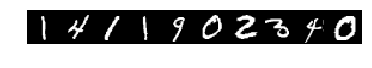

In [13]:
# check the images

print(images[:10,...])

imgs_to_visualize = tfgan.eval.image_reshaper(images[:10,...], num_cols=10)
visualizer.pre_train_image(imgs_to_visualize, save=True)

#### Define model

In [14]:
noise_dims = 8 * 8  # shape of noise generation

conditional_gan_model = tfgan.gan_model(generator_fn=tf_nets.generator,
                                        discriminator_fn=tf_nets.discriminator,
                                        real_data=images,
                                        generator_inputs=(tf.random_normal([batch_size, noise_dims]),one_hot_labels))


Tensor("Discriminator/fully_connected_2/BiasAdd:0", shape=(32, 1), dtype=float32)
Tensor("Discriminator_1/fully_connected_2/BiasAdd:0", shape=(32, 1), dtype=float32)


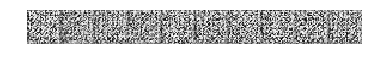

In [15]:
# check pre-training generator images
cond_generated_data_to_visualize = tfgan.eval.image_reshaper(conditional_gan_model.generated_data[:10,...], num_cols=10)
visualizer.pre_train_image(cond_generated_data_to_visualize, save=True)


In [16]:
loss = tfgan.gan_loss(conditional_gan_model, gradient_penalty_weight=1.0)
evaluate.gan_loss(loss)  # test loss function


Tensor("Discriminator_2/fully_connected_2/BiasAdd:0", shape=(32, 1), dtype=float32)
Generator loss: -0.984543
Discriminator loss: 0.082343


(-0.9845427, 0.082343064)

In [17]:
generator_optimizer = tf.train.AdamOptimizer(0.0009, beta1=0.5)  # instantiate optimizers
discriminator_optimizer = tf.train.AdamOptimizer(0.00009, beta1=0.5)

In [18]:
gan_train_ops = tfgan.gan_train_ops(conditional_gan_model, loss, generator_optimizer, discriminator_optimizer)

In [19]:
images_to_eval = 500
assert images_to_eval % 10 == 0  # ensure multiples of 10

In [20]:
random_noise = tf.random_normal([images_to_eval, 64])
one_hot_labels = tf.one_hot([i for _ in range(images_to_eval // 10) for i in range(10)], depth=10)

In [21]:
with tf.variable_scope(conditional_gan_model.generator_scope, reuse=True):
    eval_images = conditional_gan_model.generator_fn((random_noise, one_hot_labels))

In [22]:
# editing

reshaped_eval_imgs = tfgan.eval.image_reshaper(eval_images[:100, ...], num_cols=10)

Using a pretrained classifier to save on training time.

In [23]:
MNIST_CLASSIFIER_FROZEN_GRAPH = 'mnist/data/classify_mnist_graph_def.pb'  # frozen graph from google
xent_score = util.mnist_cross_entropy(eval_images, one_hot_labels, MNIST_CLASSIFIER_FROZEN_GRAPH)

In [24]:
global_step = tf.train.get_or_create_global_step()
train_step_fn = tfgan.get_sequential_train_steps()

loss_values, xent_score_values = [], []

Run the FlowGraph.

Step 0.
Current loss: -0.13
Current cross entropy score: 3.18
Training step: 0
Time since start: 0.045318 m
Steps per min: 0.000000


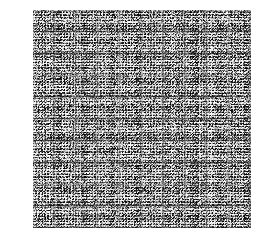

Step 100.
Current loss: -0.15
Current cross entropy score: 0.29
Training step: 100
Time since start: 1.003625 m
Steps per min: 99.638856


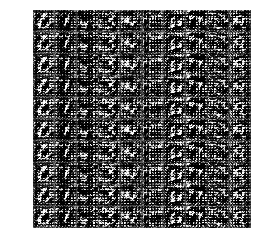

Model saved in file: assets/saved_models/model.ckpt


In [25]:
with tf.Session() as sess:
    saver = tf.train.Saver()  # instantiate saver
    init = tf.global_variables_initializer()  # initialize variables
    sess.run(init)  # run!

    with slim.queues.QueueRunners(sess):        
        start_time = time.time()  # start timer
        for i in range(1001):  # number of steps - reduced from 5000 for run time
            cur_loss, _ = train_step_fn(sess, gan_train_ops, global_step, train_step_kwargs={})            
            loss_values.append((i, cur_loss))

            if i % 25 == 0:  # 
                xent_score_values.append((i, sess.run(xent_score)))

            if i % 100 == 0:
                print(f"Step {i}.")
                print(f'Current loss: {cur_loss:.2f}')
                print(f'Current cross entropy score: {xent_score_values[-1][1]:.2f}')
                visualizer.generated_image(i, start_time, sess.run(reshaped_eval_imgs), save=True)
                plt.show()

        #  program complete
        save_path = saver.save(sess, "assets/saved_models/model.ckpt")
        print(f"Model saved in file: {save_path}")


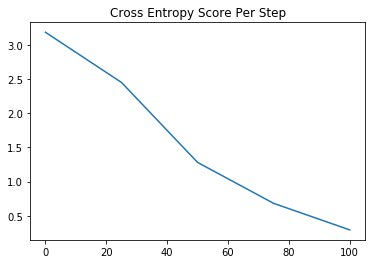

In [26]:
# plt cross entropy score
plt.title('Cross Entropy Score Per Step')  # plot cross entropy scores
plt.plot(*zip(*xent_score_values))
plt.savefig('cross_entropy.png', dpi=250)


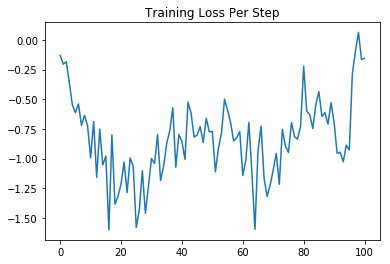

In [27]:
# plot loss
plt.title('Training Loss Per Step')
plt.plot(*zip(*loss_values))
plt.savefig('loss.png', dpi=250)
